In [1]:
import sys
import matplotlib
import matplotlib.colors

sys.path.append("..")
import jabble.model
import jabble.dataset
import jabble.loss
import jabble.physics 
import jabble.plotting
import astropy.units as u

import h5py 
import matplotlib.pyplot as plt
import scipy.optimize

# from jaxopt import GaussNewton
import jax.numpy as jnp
import jax
import numpy as np
# from mpl_axes_aligner import align

import os
import datetime
import jabble.physics

import jax
# import jax.config

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

/home/mdd423/wobble_jax/notebooks/../jabble/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound



<h1>02 - Fitting RVs to HARPS e2ds Spectra</h1>
In this notebook, I am will show you how to load in data and metadata to jabble.data objects. Then fit models to each component of the data. Due to some edge errors with normalizing near the edge of the orders in the HARPS spectrograph, we fit a longer wavelength component normalization model.


Create output directory here as the current date.

In [2]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax/','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
out_dir

'/scratch/mdd423/wobble_jax/out/25-06-16'

In [4]:
file_b = h5py.File("../data/barnards_e2ds.hdf5", "r")
file_p = h5py.File("../data/51peg_e2ds.hdf5"   , "r")

In [5]:
file_b['dates']

<HDF5 dataset "dates": shape (306,), type "<f8">

In [6]:
# jax.print_environment_info()


<h2>Jabble.Dataset</h2>
The 4 fields needed to create a jabble.data object are: xs, ys, yivar, and mask. xs is the input to whats being modeled, this should be a list of 1 dimensional jax.numpy arrays, which may have different shapes (lengths). These correspond to the log wavelength values being evaluated. The logarithm of wavelength means that the redshift from relative radial velocity change becomes an additive property.

$$x_{obs} = \log(\lambda_{obs})$$
$$\lambda_{obs} = \sqrt{\frac{1 + RV/c}{1- RV/c}}\lambda_{emit}$$
$$x_{obs} = \log(\sqrt{\frac{1 + RV/c}{1- RV/c}}\lambda_{emit})$$
$$x_{obs} = \log(\sqrt{\frac{1 + RV/c}{1- RV/c}}) + \log(\lambda_{emit})$$
$$x_{obs} = \delta x + x_{emit}$$

where $x_{obs}$ is the observed log wavelength, $RV$ is the radial velocity, $c$ is the speed of light, and $x_{emit}$ is the emitted log wavelength. ys is the measured log flux at that log wavelength, xs. This value is assumed to be in photon per wavelength bin. Thus, multiplicative properties like absorption from tellurics become additive in the logarithm. 

$$y = \log(f)$$
$$y = \log(f_s f_t) $$
$$y = \log(f_s) + \log(f_t) $$
$$y = y_s + y_t$$

yivar stands for y inverse variance, or y information. This value is produced by the instrumentation team at these detectors using some assumption about instrument readout and dark current properties along with poisson photon noise. Thus the error on the flux is not being modeled here and is assumed as correct from the pipeline. These errors are given as the standard deviation of the flux, so we need to transform error of f into the error in logarithm of flux.

$$\sigma_y = \sigma_f \frac{dy}{df}$$
$$\sigma_y = \frac{\sigma_f}{f}$$

In [7]:
def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping

    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do

    Returns:
        The value of the continuum at the wavelengths in x
        Author: Megan Bedell

    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w, _, _, _ = np.linalg.lstsq(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        # print(m.shape,m_new.shape)
        m = m_new
    return mu

In [8]:
def get_dataset(file,orders,device):
    ys = []
    xs = []
    yivar = []
    mask = []

    init_rvs = np.array(file["bervs"])
    times_t = np.array([x for x in file["dates"]])
    full_init_rvs = []
    # print(file["bervs"].shape)
    airmass = []
    order_out = []
    times = []
    star_ids = []

    for iii in orders:
        for jjj in range(file["data"].shape[1]):
            contin = fit_continuum(np.array(file["xs"][iii,jjj,:]),np.array(file["data"][iii,jjj,:]),np.array(file["ivars"][iii,jjj,:]),\
                                   order=6, nsigma=[0.3,3.0], maxniter=50)
            
            ys.append(jnp.array(file["data"][iii,jjj,:]) - contin)
            xs.append(jnp.array(file["xs"][iii,jjj,:]))
            yivar.append(jnp.array(file["ivars"][iii,jjj,:]))
            mask.append(jnp.zeros(file["data"][iii,jjj,:].shape,dtype=bool))

            # init_shifts.append(
            airmass.append(file["airms"][jjj])
            order_out.append(iii)
            times.append(file["dates"][jjj])
            star_ids.append(str(file))

            full_init_rvs.append(file["bervs"][jjj])
    
    full_init_rvs = jnp.array(full_init_rvs)
    airmass = jnp.array(airmass)

    dataset = jabble.dataset.Data.from_lists(xs,ys,yivar,mask)

    dataset.metakeys['times'] = times_t
    dataset.metadata['times'] = np.array(times)
    dataset.metadata['orders'] = np.array(order_out)
    dataset.metadata['star_ids'] = np.array(star_ids)
    dataset.metadata['init_rvs'] = np.array(full_init_rvs)

    dataset.metadata['airmass'] = airmass
    dataset.metadata['bervs'] = full_init_rvs
    dataset.to_device(device)
    
    # init_shifts = jax.device_put(init_shifts,device)
    # airmass = jax.device_put(airmass,device)
    
    return dataset, init_rvs, airmass, full_init_rvs, times_t

<h2>Jabble.Model</h2>
Now, we will define the components of the model. These stars will have 3 components: stellar, telluric, pseudo-normalization. 

$$y = y_\mathrm{s} + y_\mathrm{t} + y_\mathrm{N}$$

The stellar component will be be high resolution (twice R of the detector) in wavelength and static in flux across all times or epochs of data. However, a nonlinear comes from the redshift radial velocity being fit inside the linear model log flux model. Because our dataset will consist of different orders at the same time, and the same order at different time, and we are assuming the wavelenght solution to be true. Thus the redshift should be the same at different orders at the same time, so $i_*$ is the index of the epoch while $i$ is the data index, which is different for all orders and times or can be thought of simply as the data index.

$$y_s = f(x + \delta x_{i_*}|\theta_\mathrm{s})$$

The tellurics model is also high resolution in wavelength and static across all times, but the airmass is used to stretch the model at each model at each time. This parameter is not fit, however is can be if the user chooses to do so!

$$y_t = a_i f(x|\theta_\mathrm{t})$$

And finally the pseudo-normalization model is low resolution in wavelength about one parameter per 50 Angstroms and is different across all times because we expect the detector state to vary greatly with time.

$$y_\mathrm{N} = f(x|\theta_{\mathrm{N},i})$$

The function we choose to represent the flux of these models is the cardinal spline mixture, who are evenly spaced in wavelength. 

$$f(x|\theta,p) = \sum_i \theta_i k(x|p,i)$$

where $k$ is the cardinal basis/kernel function. This basis function is a piecewise polynomial positioned on an evenly spaced grid such that the total function will be continuous in $p-1$ derivatives.

In [9]:
import jabble.quickplay
def get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_vels,airmass,pts_per_wavelength,norm_p_val):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    # model = jabble.quickplay.get_wobble_model(init_rvs, airmass, model_grid, p_val,rest_vels) #+ jabble.quickplay.get_normalization_model(dataset,norm_p_val,pts_per_wavelength)

    # model = jabble.quickplay.PseudoNormalModel(init_shifts, init_airmass, model_grid, p_val, dataset, norm_p_val, pts_per_wavelength)
    init_shifts = jabble.physics.shifts(init_rvs)
    rest_shifts = jabble.physics.shifts(rest_vels)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts,which_key='times'),#ShiftingModel(init_shifts),#
            jabble.model.CardinalSplineMixture(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts,which_key='times'),
            jabble.model.CardinalSplineMixture(model_grid, p_val),
            jabble.model.StretchingModel(airmass),
        ]
    ) #+ jabble.model.get_normalization_model(dataset,norm_p_val,pts_per_wavelength)

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

<h2>Training Cycle</h2>
Now we define the fitting process of the parameters of all of these models with respect to the total set of data. This is require some clever initialization, so that we don't end up too far from the solution. First, we fit the parameters of the tellurics, stellar, normalization model. Regularizing the stellar and tellurics components, so that they are close 0. Then we fit the RV alone. Then we optimize everything together with regularization on the stellar and tellurics component.

In [10]:
def train_cycle(model, dataset, loss, device_store, device_op, batch_size):
    options = {"maxiter": 4096}
    
    # Fit Normalization Template
    # model.fix()
    # model.fit(2, 1)
    # # model.fit(0,1)
    # # model.fit(1,1)
    # # model.display()
    
    # res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    # print(res1)

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(0,1)
    model.fit(1,1)
    model.display()
    
    res1 = model.optimize(loss + reg_s + reg_t, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0,0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # RV Parabola Fit
    # model.fix()
    # shift_search = jabble.physics.shifts(np.linspace(-50, 50, 100))
    # model[0][0].parabola_fit(shift_search, loss, model, dataset, device_op, device_store)
    # model.to_device(device_op)
    # print(type(model_p[0][0].p))

    # Fit Everything
    model.fix()
    model.fit(0,0)
    model.fit(0,1)
    model.fit(1,1)

    res1 = model.optimize(loss + reg_s + reg_t, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

Here we define the 'loss' to be the sum of the chi squared of each flux. This is typical choice when using jabble, and why we must define the inverse variance of y, $I_{y}$ in the data object.

$$\mathcal{L}_{\chi^2} = \sum I_y (ys - y(xs|\delta x_{i_*},\theta_\mathrm{s},\theta_\mathrm{t},\theta_{\mathrm{N},i}) )^2$$

$xs, ys, I_{y}$ are from the data and are then summed over all unmasked elements.

$$\mathcal{L}_{\mathrm{reg}} = \sum \theta_\mathrm{s}^2 + \theta_\mathrm{t}^2$$

$$\mathcal{L}_{total} = \mathcal{L}_{\chi^2} + \lambda \mathcal{L}_{\mathrm{reg}}$$

In [12]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")
loss = jabble.loss.ChiSquare()

Here we define the parameters of the instrument that are needed to build our model. The instrument is HARPS, so the resolution is 115,000. The $p$ value for the CSM model on the stellar and telluric components is set to 2. This means just the first derivative of the model will be continuous. And we will add a wavelength padding to either side of the log wavelength grid out to $100$ km/s in log wavelength. And the lambda for the regularization term is defined here as $\lambda = 100$.

In [13]:
resolution = 115_000
p_val = 3
vel_padding = 100 * u.km / u.s


pts_per_wavelengths = [1/25.0]
norm_p_vals = [3]
lmbs = [1e-6]

star_name_b, star_name_p = 'barnards','peg51'

We will not fit the entire spectrum in one pass but we will fit chunks of multiple orders with one RV per epoch.

In [14]:
orders_s = np.arange(0,72,dtype=int)[:,None].reshape(-1,2)
print(orders_s)
# orders_s = [[34]]

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]
 [20 21]
 [22 23]
 [24 25]
 [26 27]
 [28 29]
 [30 31]
 [32 33]
 [34 35]
 [36 37]
 [38 39]
 [40 41]
 [42 43]
 [44 45]
 [46 47]
 [48 49]
 [50 51]
 [52 53]
 [54 55]
 [56 57]
 [58 59]
 [60 61]
 [62 63]
 [64 65]
 [66 67]
 [68 69]
 [70 71]]


Also decide what device you want to store extra data on, and which device to put the model and do the fitting on.

In [15]:
file_b.filename

'../data/barnards_e2ds.hdf5'

In [16]:
# device_store = cpus[0]
# device_op = gpus[0]
# batch_size = 5000

# for orders in orders_s:
#     for star_name,file in zip([star_name_b,star_name_p],[file_b,file_p]):
#         os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)
#         for lmb in lmbs:
#             for norm_p_val in norm_p_vals:
#                 for pts_per_wavelength in pts_per_wavelengths:
#                     data_name = os.path.join(out_dir,star_name,star_name + '_data_o{}_pre_norm.pkl'.format(orders))
#                     model_name = os.path.join(out_dir,star_name,star_name + '_model_o{}_pre_norm.pkl'.format(orders))
#                     dataset, init_rvs, airmass, full_init_rvs, times_t = get_dataset(file,orders,device_op)

#                     print(lmb*np.sum(np.concatenate(dataset.yivar)))
#                     # continue
#                     # print(init_rvs.shape,full_init_rvs.shape)
#                     datablock, metablock, meta_keys = dataset.blockify(device_store,return_keys=True)
#                     # print(datablock,metablock)
#                     # for datarow in datablock:
#                     #     print(datarow)
#                     # break

#                     rest_rvs = jnp.zeros(init_rvs.shape)
#                     model = get_model(dataset,resolution,p_val,vel_padding,-init_rvs,rest_rvs,airmass,pts_per_wavelength,norm_p_val)
                    
#                     # break
#                     model.metadata["dataset"] = file.filename
#                     for key in dataset.metadata.keys():
#                         model.metadata[key] = dataset.metadata[key]
                    
#                     model.to_device(device_op)
#                     reg_s = lmb*np.sum(np.concatenate(dataset.yivar))*jabble.loss.L2Reg([0,1])
#                     reg_t = lmb*np.sum(np.concatenate(dataset.yivar))*jabble.loss.L2Reg([1,1])
#                     model = train_cycle(model, dataset, loss + reg_s + reg_t, device_store, device_op, batch_size)
#                     # model.display()

#                     model.fix()
#                     model.fit(0,1)
#                     model.fit(1,1)
#                     reg_s.ready_indices(model)
#                     reg_t.ready_indices(model)
#                     jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,\
#                                           device=device_op,loss=loss+reg_s+reg_t)
#                     # jabble.quickplay.save(model,model_name,mode="pkl",data=dataset,device=device_op)

#                     # with h5py.File(model_name + '.hdf','r') as file:
#                     # print(model_name + '.hdf',file.keys())
#                     # model = jabble.quickplay.load(model_name + '.hdf','hdf')
#                         # for key in file.keys():
#                         #     cls = eval('jabble.model.' + key)
#                         #     model = cls.load_hdf(cls,file)
#                         #     model.display()
#                         #     print(model.results)
#                         # print(file['AdditiveModel']['[0]CompositeModel']['[0][1]CardinalSplineMixture']['p_val'])
#                     # break
#                     # jabble.quickplay.load()
#                     # jabble.model.save(model_name,model)

In [17]:
# print(model.results)
# ls_means = np.ceil([np.exp(dataset.xs[xxx][:]) for xxx in rv_inds]).mean(axis=1)
# lrange = ls_means[:,None] + np.arange(-5,5,2)[None,:]
# # print(lrange)
# # lrange = np.repeat(lrange,len(rv_inds),axis=0) + np.zeros(len(rv_inds))[:,None]
# plt_name = "{}_spectra_test.png".format(star_name,orders)
# print(lrange)
# jabble.plotting.make_order_plot(dataset,model,lrange,rv_inds,cpus[0],plt_name)
# #(dataset,model,lrange,rv_inds,device,plt_name=None)

def make_deriv_plots(dataset,model,plt_epoch,device,plt_name):
    l_width = np.arange(-0.5,0.5,0.2) + 11.5
    
    fig, axes = plt.subplots(3,figsize=(5,5),sharex='col',\
                             facecolor=(1, 1, 1),height_ratios=[1,1,1],dpi=200)
    data, meta, keys = dataset.blockify(device,return_keys=True)

    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    
    lrange = np.floor(np.exp(datarow['xs']).mean()) + l_width

    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    model.fix()
    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    yhat = model([],dataset.xs[plt_epoch][:],metarow)
    
    velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    axes[0].errorbar(datarow["xs"][:],datarow["ys"][:],yerr=1/np.sqrt(datarow["yivar"][:]),fmt='ok',zorder=3,alpha=0.5,ms=1)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=2,alpha=0.5,ms=6)
    # Telluric Model
    axes[0].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    axes[0].set_yticks([])
    # axes[0].set_ylim(-3,1)
    axes[0].set_ylabel('f')
    
    model.fix()
    model.fit(0,0)
    deriv_model = jax.jacfwd(model,argnums=0)(model.get_parameters(),datarow['xs'],metarow)
    deriv_model_plot = jax.jacfwd(model,argnums=0)(model.get_parameters(),xplot,metarow)
    print(deriv_model.shape)
    # deriv_axes = axes[0].twinx()
    axes[1].plot(xplot,deriv_model_plot[:,plt_epoch],'y',alpha=0.5,ms=6)
    axes[1].plot(xplot,np.zeros(xplot.shape[0]),'-k',alpha=0.3,linewidth=1,zorder=-1)
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_yticks([])
    axes[1].set_ylabel(' $\\frac{\\partial f}{\\partial \\delta x}$')

    # info_axes = axes[0].twinx()
    axes[2].step(datarow['xs'],deriv_model[:,plt_epoch]*datarow['yivar']*deriv_model[:,plt_epoch],where='mid',alpha=0.5,ms=4,c='g')
    axes[2].plot(xplot,np.zeros(xplot.shape[0]),'-k',alpha=0.3,linewidth=1,zorder=-1)

    axes[2].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[2].set_yticks([])
    axes[2].set_ylabel(' $\\frac{\\partial f}{\\partial \\delta x} I_{y} \\frac{\\partial f}{\\partial \\delta x}$')
    # deriv_axes.set_ylim(-1e4,1e4)

    axes[0].set_xlim(xplot.min(),xplot.max())
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
        
    fig.text(0.5, 0.00, 'Wavelength $[\AA]$', ha='center')
    # fig.text(0.08, 0.5, 'Normalized Flux', va='center', rotation='vertical')
    if plt_name is not None:
        plt.savefig(os.path.join(out_dir, plt_name),bbox_inches='tight')
    plt.show()

In [18]:
# make_deriv_plots(all_data[0],all_models[0],40,cpus[0],'info.png')

In [19]:
# def get_savable_attr(model):
#     for key in model.__dict__:
#         # print(key)
#         if key[0] != "_":
#             # print(key)
#             if '__len__' in dir(model.__dict__[key]):
#                 if len(model.__dict__[key]) != 0:
#                     print(key,model.__dict__[key])
#                     if key == "models":
#                        for submodel in model.models:
#                             get_savable_attr(submodel)
# get_savable_attr(model)

In [20]:
import glob
dir = glob.glob('/scratch/mdd423/wobble_jax/out/25-05-08/barnards/*.pkl')
print(len(dir))

72


In [21]:
# import inspect
# lines = inspect.getsource(jabble.quickplay.save)
# print(lines)

In [22]:
# def recurse_hdf(file):
#     print(file.keys())
#     for key in file.keys():
#         # print(key)
#         if isinstance(file[key], h5py.Group):
            
#             recurse_hdf(file[key])
#         if key == "results":
#             print("yes")

# def load_hdf(filename):
#     with h5py.File(filename,'r') as file: 
#         print(filename)
#         for key in file.keys():
#             print(file,key,type(file[key]))
#             if isinstance(file[key], h5py.Group):
#                 print(key)
#                 cls = eval(key)
#                 model = cls.load_hdf(cls,file[key])
#                 # recurse_hdf(group[key])
#     return model
# #model_name + '.hdf'
# with h5py.File(dir[0],'r') as file: 
#     # recurse_hdf(dir[0])
#     print(file.keys())
#     # for key in file.keys():
#     #     print(key)
#     #     if key in dir(jabble.model):
#     #         print("yes")
# # load_hdf(dir[0])

In [23]:
out_dir

'/scratch/mdd423/wobble_jax/out/25-06-16'

In [153]:
summary_path = "/scratch/mdd423/wobble_jax/out/25-05-08/barnards"
dir_files = glob.glob(os.path.join(summary_path,'*_RVS.hdf'))

In [154]:
print([*zip(np.arange(0,4).reshape(2,2),np.ones(2))])
import jabble.quickplay

[(array([0, 1]), 1.0), (array([2, 3]), 1.0)]


In [155]:
rv_array, all_models, all_rv_array, all_data = jabble.quickplay.load_model_dir(summary_path,dir_files,cpus[0],force_run=True)

In [156]:
print([model.results for model in all_models])

[array([('CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',   6,   8, 0, 622897.4142591 , '1.0 ChiSquare() + 1000.0 L2Reg([0, 1]) + 1000.0 L2Reg([1, 1])'),
       ('CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 109, 125, 0, 595526.3103085 , '1.0 ChiSquare()'),
       ('CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',   1,   7, 0, 622741.51878631, '1.0 ChiSquare() + 1000.0 L2Reg([0, 1]) + 1000.0 L2Reg([1, 1])')],
      dtype=[('task', '<U64'), ('nit', '<i8'), ('funcalls', '<i8'), ('warnflag', '<i8'), ('value', '<f8'), ('loss', '<U64')]), array([('CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 11,  14, 0, 1404525.00665047, '1.0 ChiSquare() + 1000.0 L2Reg([0, 1]) + 1000.0 L2Reg([1, 1])'),
       ('CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 94, 106, 0, 1311545.93174853, '1.0 ChiSquare()'),
       ('CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',  1,   6, 0, 1402625.97009601, '1.0 ChiSquare() + 1000.0 L2Reg([0, 1]) + 1000.0 L2Reg([1, 1])')],
      dtype=[('task', '<U64'), (

In [157]:
all_rv_array['Loss_Avg'].shape,all_rv_array['RV_all'].shape,all_rv_array['Time_all'].shape

((36, 306), (36, 306), (36, 306))

In [158]:
import matplotlib.ticker as ticker
import cmasher

In [159]:
plt.rcParams['text.usetex'] = True

2.3810705949075914
1.2684676935549097


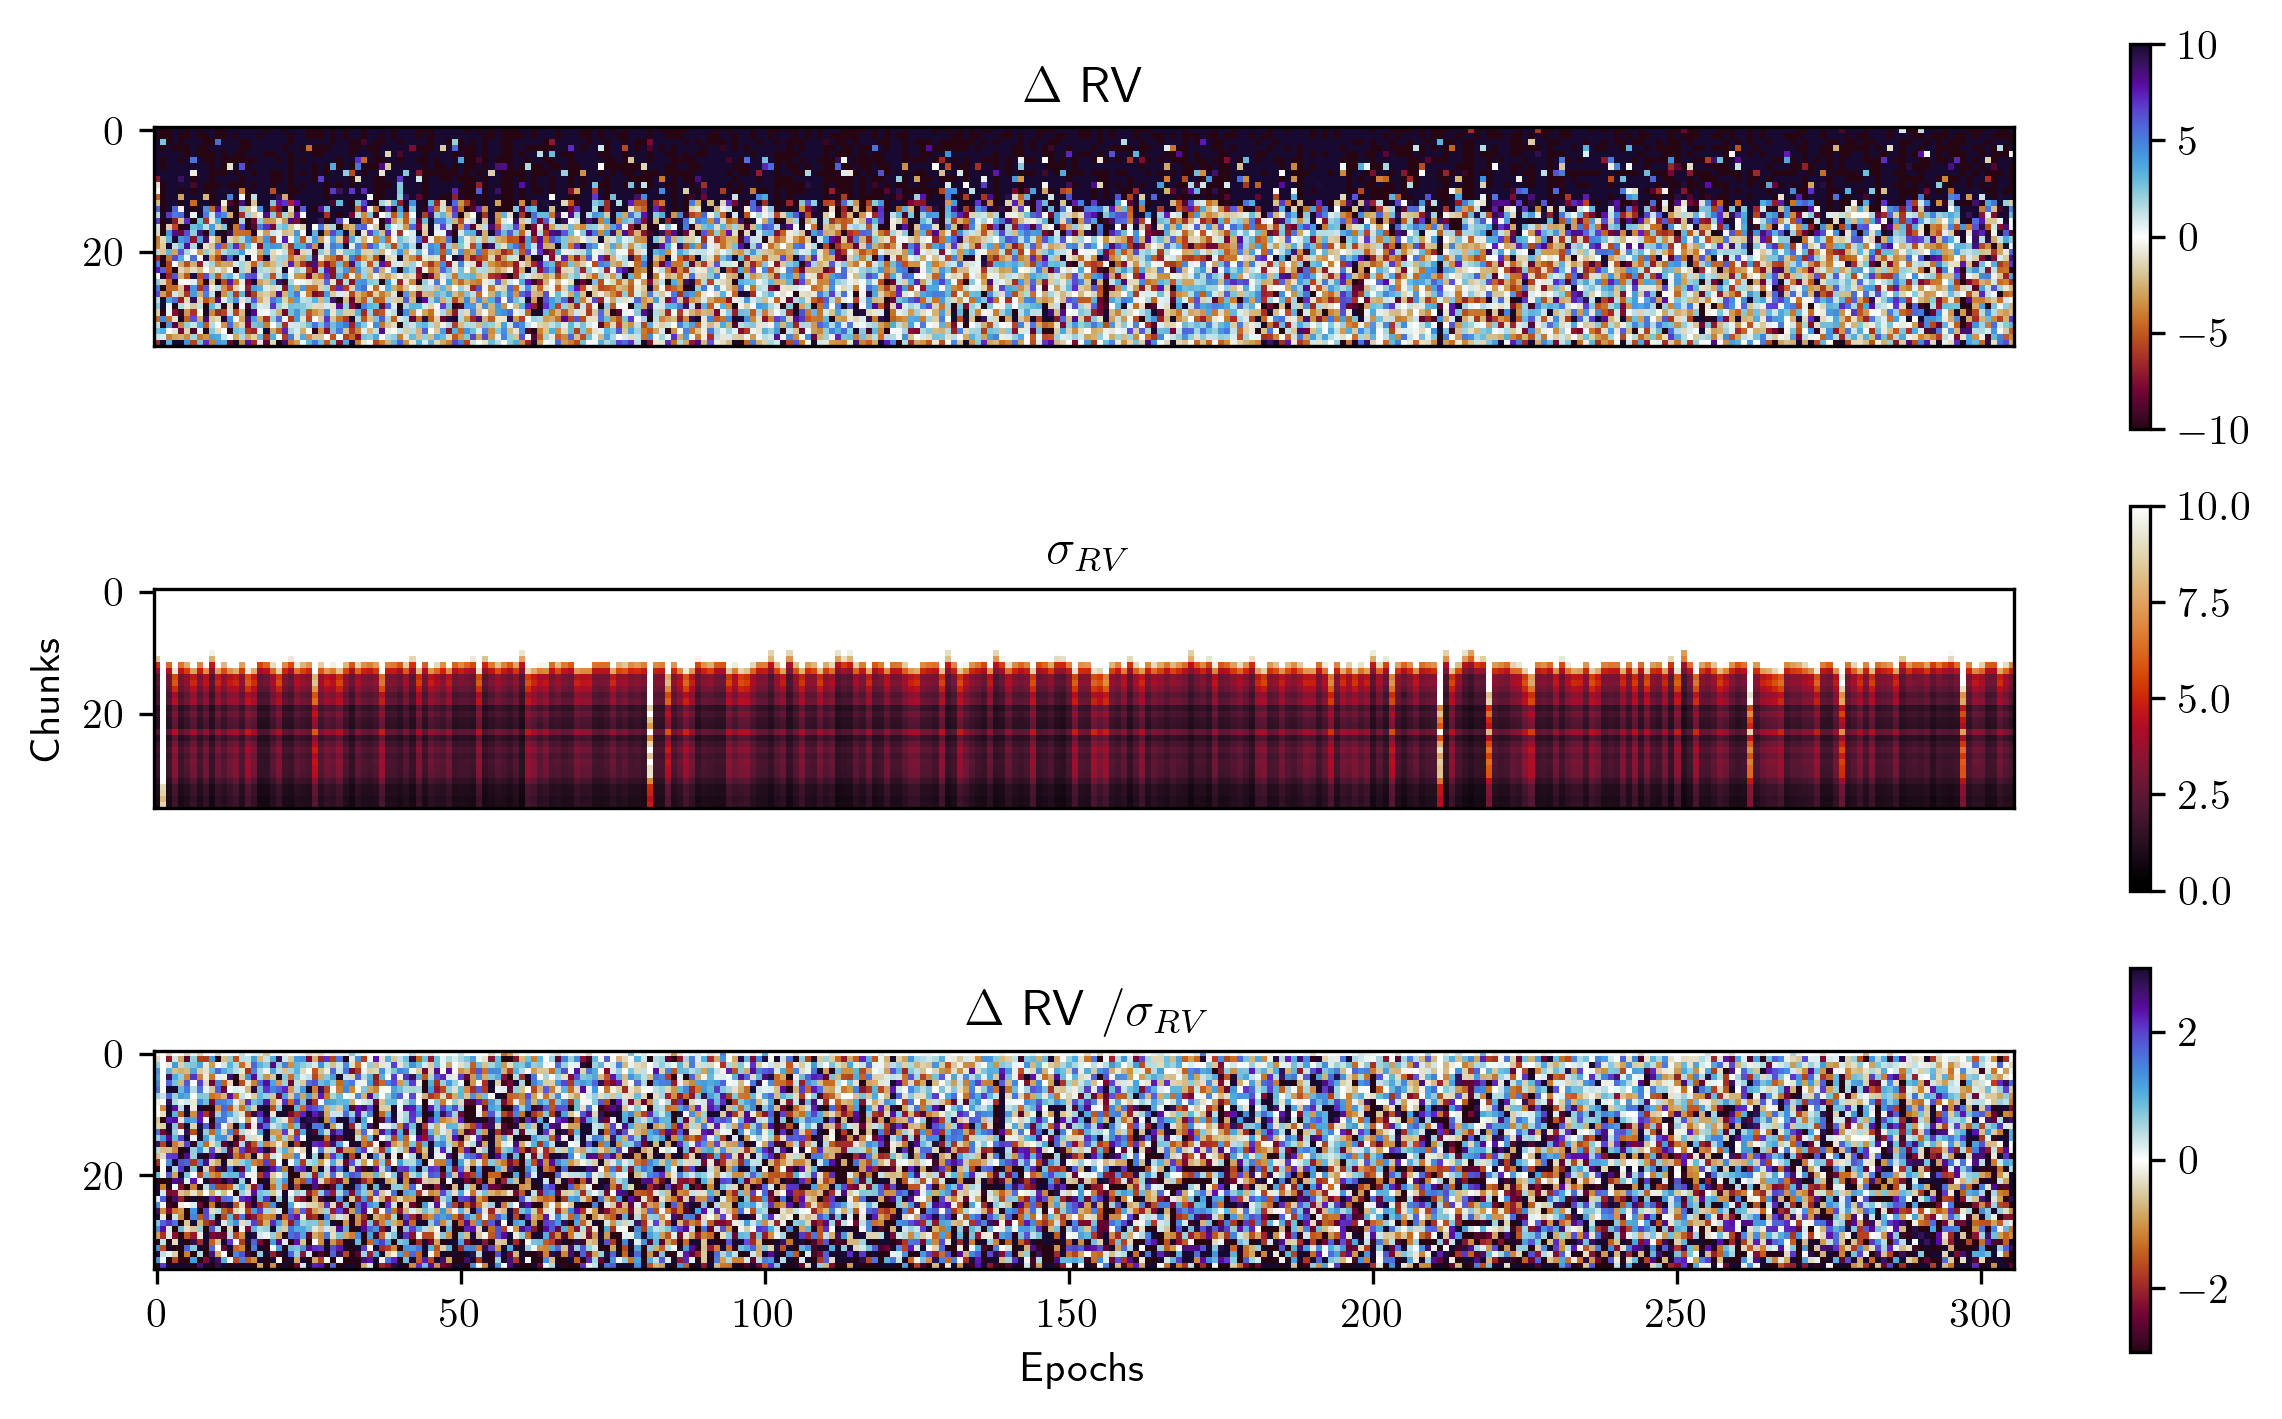

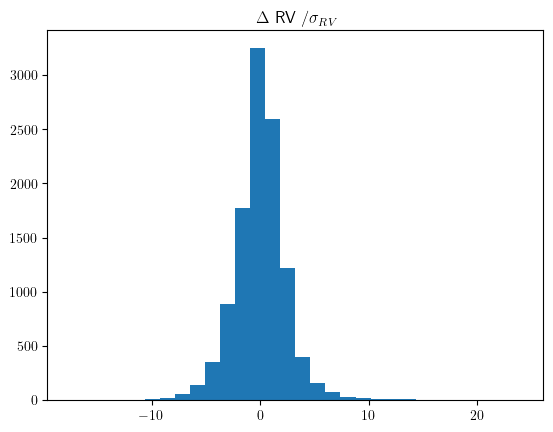

In [160]:
# rv_all_order_plot(all_tim,all_rvs,all_err,\
#                   rv_array['Time_comb'],rv_array['RV_comb'],rv_array['RV_err_comb'],\
#                   np.array(file_b['dates']),np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']),\
#                   np.array(file_b['bervs']))
star_name = "barnards"
jabble.plotting.plot_rv_difference(all_rv_array['Time_all'],all_rv_array['RV_all'],all_rv_array['RV_err_all'],\
                        rv_array['Time_comb'],rv_array['RV_comb'],rv_array['RV_err_comb'],\
                        np.array(file_b['dates']),np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']),\
                        np.array(file_b['bervs']),all_rv_array['Loss_Avg'],all_rv_array['RV_difference'],star_name,\
                                   out_dir=out_dir,sigma_max=10,difference_max=10,top_spacing=1.2)

1.2684676935549097 2.3810705949075914


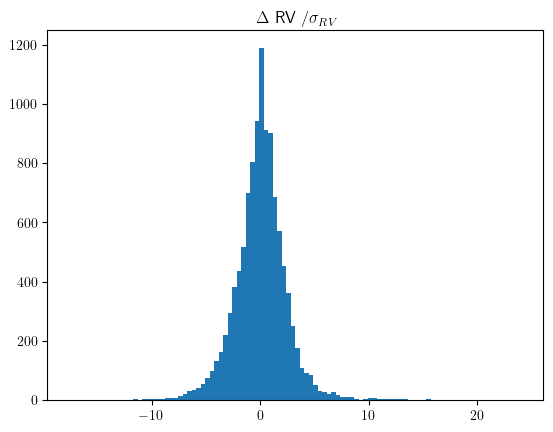

In [161]:
plt.hist((all_rv_array['RV_difference']/all_rv_array['RV_err_all']).flatten(),bins=100)
print(np.median(np.abs((all_rv_array['RV_difference']/all_rv_array['RV_err_all']))),\
      np.sqrt(np.mean((all_rv_array['RV_difference']/all_rv_array['RV_err_all'])**2)))
plt.title('$\Delta$ RV /$\sigma_{RV}$')
plt.show()

In [162]:
all_rv_array.dtype,all_rv_array['RV_all'].shape,all_rv_array['RV_err_all'].shape,\
all_rv_array['Time_all'].shape,all_rv_array['Loss_Avg'].shape,all_rv_array['RV_difference'].shape,

(dtype([('RV_all', '<f8', (306,)), ('RV_err_all', '<f8', (306,)), ('Time_all', '<f8', (306,)), ('Loss_Avg', '<f8', (306,)), ('RV_difference', '<f8', (306,)), ('min_order', '<i8')]),
 (36, 306),
 (36, 306),
 (36, 306),
 (36, 306),
 (36, 306))

In [163]:
all_rv_array["RV_all"].shape

(36, 306)

In [164]:
from astropy.io import fits

In [165]:
line_list = fits.open("~/wobble_jax/data/J_ApJ_795_23_table2.dat.fits")

In [166]:
line_list[0].header

SIMPLE  =                    T / Standard FITS Format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    0 / No Image --- just extension(s)                 
EXTEND  =                    T / There are standard extensions                  
ORIGIN  = 'CDS     '           / File generated at CDS, Strasbourg, France      
                                 (tofits, Version 3.4)                          
             e-mail:    question@simbad.u-strasbg.fr                            
COMMENT  ARG='-m -1 /ftp/cats/J/ApJ/795/23/./table2.dat'                        
LONGSTRN= 'OGIP 1.0'           / Long string convention (&/CONTINUE) may be used
DATE    = '2024-07-24'         / Written on 2024-07-24:20:54:11 (GMT)           
                             by: www-data@cdsarc.astro.unistra.fr               
CDS-CAT = 'J/ApJ/795/23'       / Catalogue designation in CDS nomenclature      
COMMENT  Line list for stell

In [167]:
# cmap = cm.get_cmap("Spectral")
cmap = matplotlib.colormaps["Spectral"]
# import cmastro

0.025 stellar radii

$1/0.025$

In [128]:
# ind_array = np.array(np.where(all_rv_array['RV_err_all'] > 1e3))
# ind_model_array = np.unique(ind_array[0])
# print(ind_model_array)
# for model_index in ind_model_array:
#     def something(rv_inds):
#         if len(rv_inds) == 1:
#             rv_inds = np.append(rv_inds,rv_inds[0]+1)
#         orders = np.unique(all_models[model_index].metadata['orders'])
#         ls_means = np.ceil([np.exp(all_data[model_index].xs[xxx][:]) for xxx in rv_inds]).min(axis=1)
        
#         lrange = ls_means[:,None] + np.arange(-5,5,4)[None,:]
#         print(lrange)
#         plt_name = "barnards_spectra_o{}_rv{}.png".format(orders,rv_inds)
#         make_order_plot(all_data[model_index],all_models[model_index],lrange,rv_inds,cpus[0],plt_name)
#     rv_inds = ind_array[1,ind_array[0,:] == model_index]
    
#     row_len = 4
#     if len(rv_inds) > row_len:
        
#         rounds = len(rv_inds)//row_len
#         for rv_inds_i in range(rounds):
#             something(rv_inds[rv_inds_i*row_len:np.min([(rv_inds_i+1)*row_len,len(rv_inds)-1])])
#             if rv_inds_i  > 3:
#                 break
#     else:
#         something(rv_inds)

In [149]:
def make_grid_plots(datasets,models,size_n,size_m,plt_epochs,device,line_list=None,l_width=np.arange(-4,4,2)):
    # l_width = 
    
    fig, axes = plt.subplots(2*size_n,size_m,figsize=(3*size_m,2*size_n),sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1]*size_n,dpi=200)
    # plt.tight_layout()

    for ii, nn in enumerate(range(size_n)):
        for jj, mm in enumerate(range(size_m)):
            this_index = size_m*ii+jj
            
            lrange = np.floor(np.exp(datasets[this_index].xs[plt_epochs[this_index]]).mean()) + l_width
            # print(lrange)
            axes[2*ii:((2*ii)+2),jj] = make_subplot(axes[2*ii:((2*ii)+2),jj],models[this_index],datasets[this_index],plt_epochs[this_index],device,lrange)
            if "orders" in models[this_index].metadata:
        
                text = axes[2*ii,jj].text(np.log(lrange.min()+0.1),-2.4,\
                                          "Order: ${}$".format(models[this_index].metadata["orders"][plt_epochs[this_index]]))
                # text.fontsize = 16
    
            if line_list is not None:
                plot_line_list(axes[2*ii:((2*ii)+2),jj],line_list,lrange)
    plt.subplots_adjust(top=1.3)

    return fig, axes

In [150]:
def make_subplot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    # yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)
    axes[0].set_xlim(xplot.min(),xplot.max())

    velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.2,ms=0.5)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=1,alpha=0.7,ms=0.5)
    # Telluric Model
    axes[0].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=1,alpha=0.7,ms=0.5)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    # axes[0,ii].plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=1)

    # if "orders" in model.metadata:
        
    #     axes[0].text(np.log(lrange.min()+0.1),0.3,"Order: ${}$".format(model.metadata["orders"][plt_epoch]))
    # axes[0].text(np.log(lrange.max()-0.1),0.3,"MJD: ${}$".format(model.metadata["times"][plt_epoch]))

    axes[0].set_ylim(-2.5,0.5)
    axes[1].set_ylim(-1,1)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange],fontsize=8)
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

[ 0  3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69]
[0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19, 21, 22, 24, 25, 27, 28, 30, 31, 33, 34] [  0 306   0 306   0 306   0 306   0 306   0 306   0 306   0 306   0 306
   0 306   0 306   0 306]


/state/partition1/job-62140155/ipykernel_1117402/922636788.py:29: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.2,ms=0.5)
/state/partition1/job-62140155/ipykernel_1117402/922636788.py:29: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.2,ms=0.5)
/state/partition1/job-62140155/ipykernel_1117402/922636788.py:29: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.2,ms=0.5)
/state/partition1/job-62140155/ipykernel_1117402/922636788.py:29: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.2,ms=0.5)
/state/partition1/job-62140155/ipykernel_1117402/922636788.py:29: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"

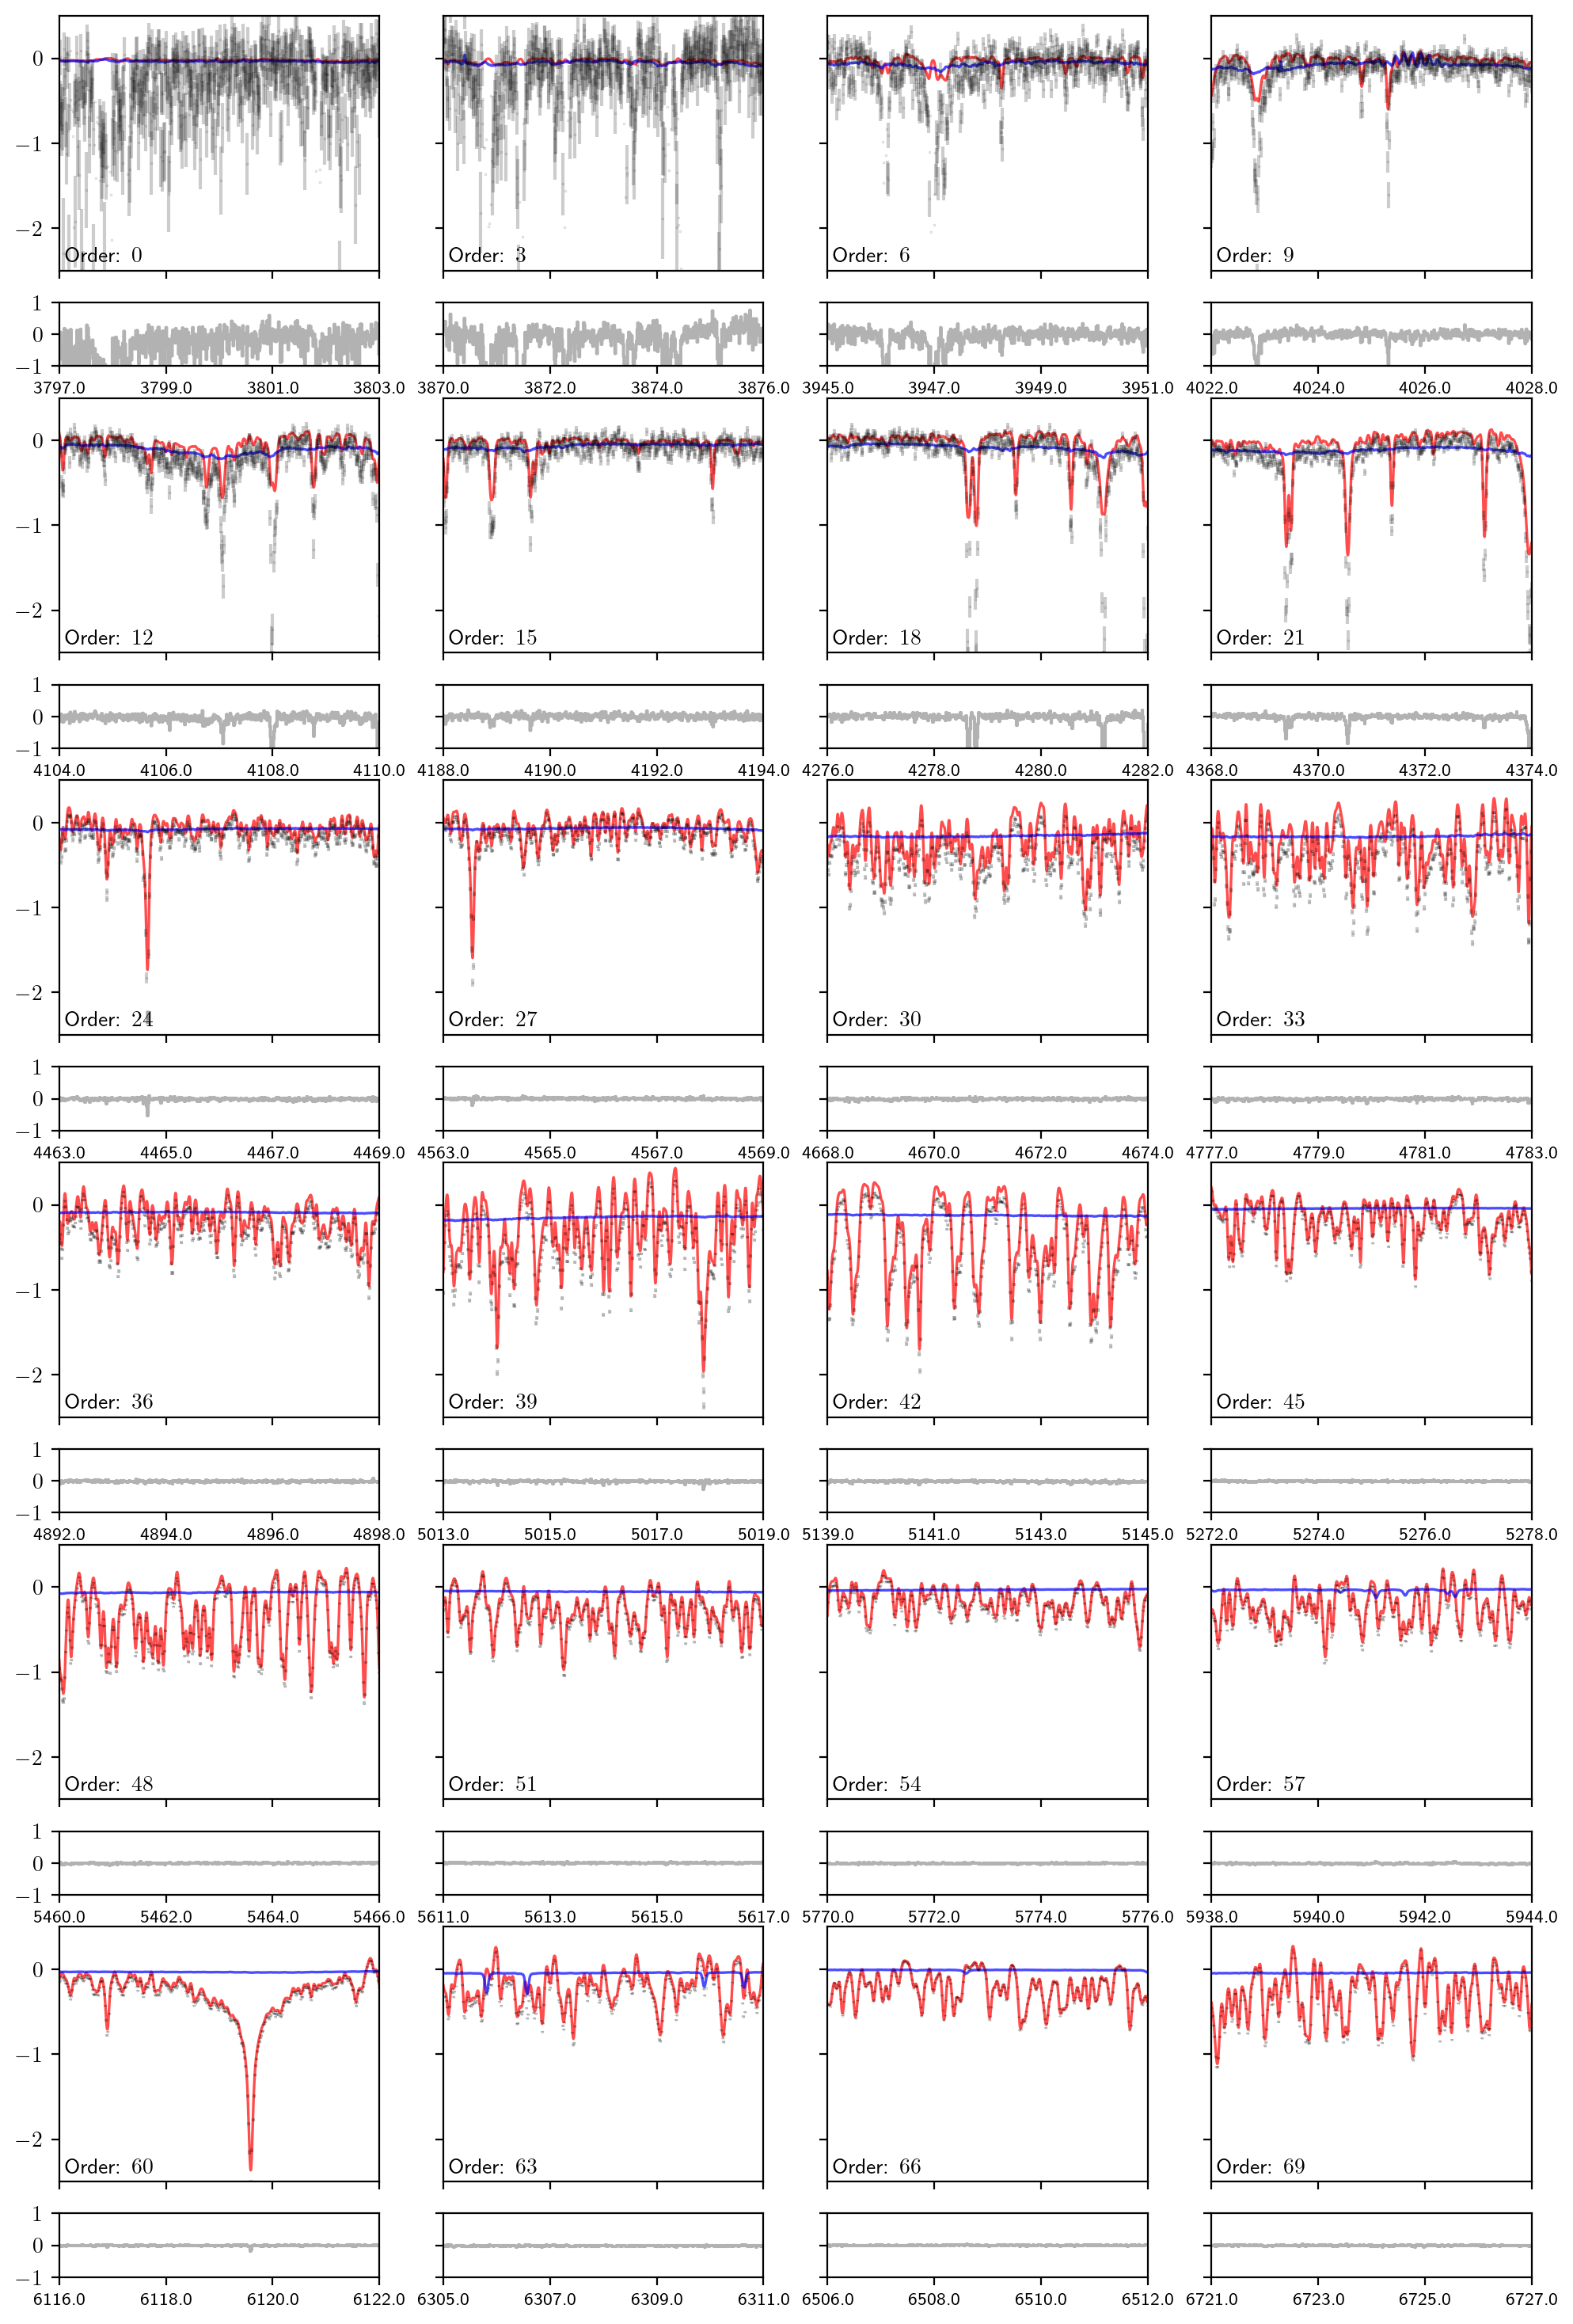

In [168]:
# (datasets,models,size_n,size_m,plt_epochs,orders)
# order_list = [np.min(model.metadata['orders']) for model in all_models]
# print(order_list)
ordered_order_list = np.array(np.argsort(order_list))
# print(ordered_order_list)
size_m = 6
size_n = 4
plt_epochs = np.zeros((size_m*size_n),dtype=int)
uni_order = [np.unique(model.metadata['orders']) for model in all_models]
plt_orders = np.arange(0,72,3)
print(plt_orders)
mdl_index = []
for order in plt_orders:
    for ii,uni in enumerate(uni_order):
        if order in uni:
            mdl_index.append(ii)

plt_epochs = []
plt_time = all_models[0].metadata['times'][0]

for order,index in zip(plt_orders,mdl_index):
    # print((all_models[index].metadata['times'] == plt_time) * (all_models[index].metadata['orders'] == order))
    tmp, = np.where((all_models[index].metadata['times'] == plt_time) * (all_models[index].metadata['orders'] == order))
    plt_epochs.append(tmp)
plt_epochs = np.array(plt_epochs,dtype=int).flatten()
print(mdl_index,plt_epochs)
plt_name="{}_pre_norm_{}-{}.png".format(star_name,plt_epochs.min(),plt_epochs.max())
fig, axes = make_grid_plots([all_data[xx] for xx in mdl_index],[all_models[xx] for xx in mdl_index],\
                                size_m,size_n,plt_epochs,cpus[0])
plt.savefig(os.path.join(out_dir,plt_name),bbox_inches='tight')
plt.show()
# plt.show()

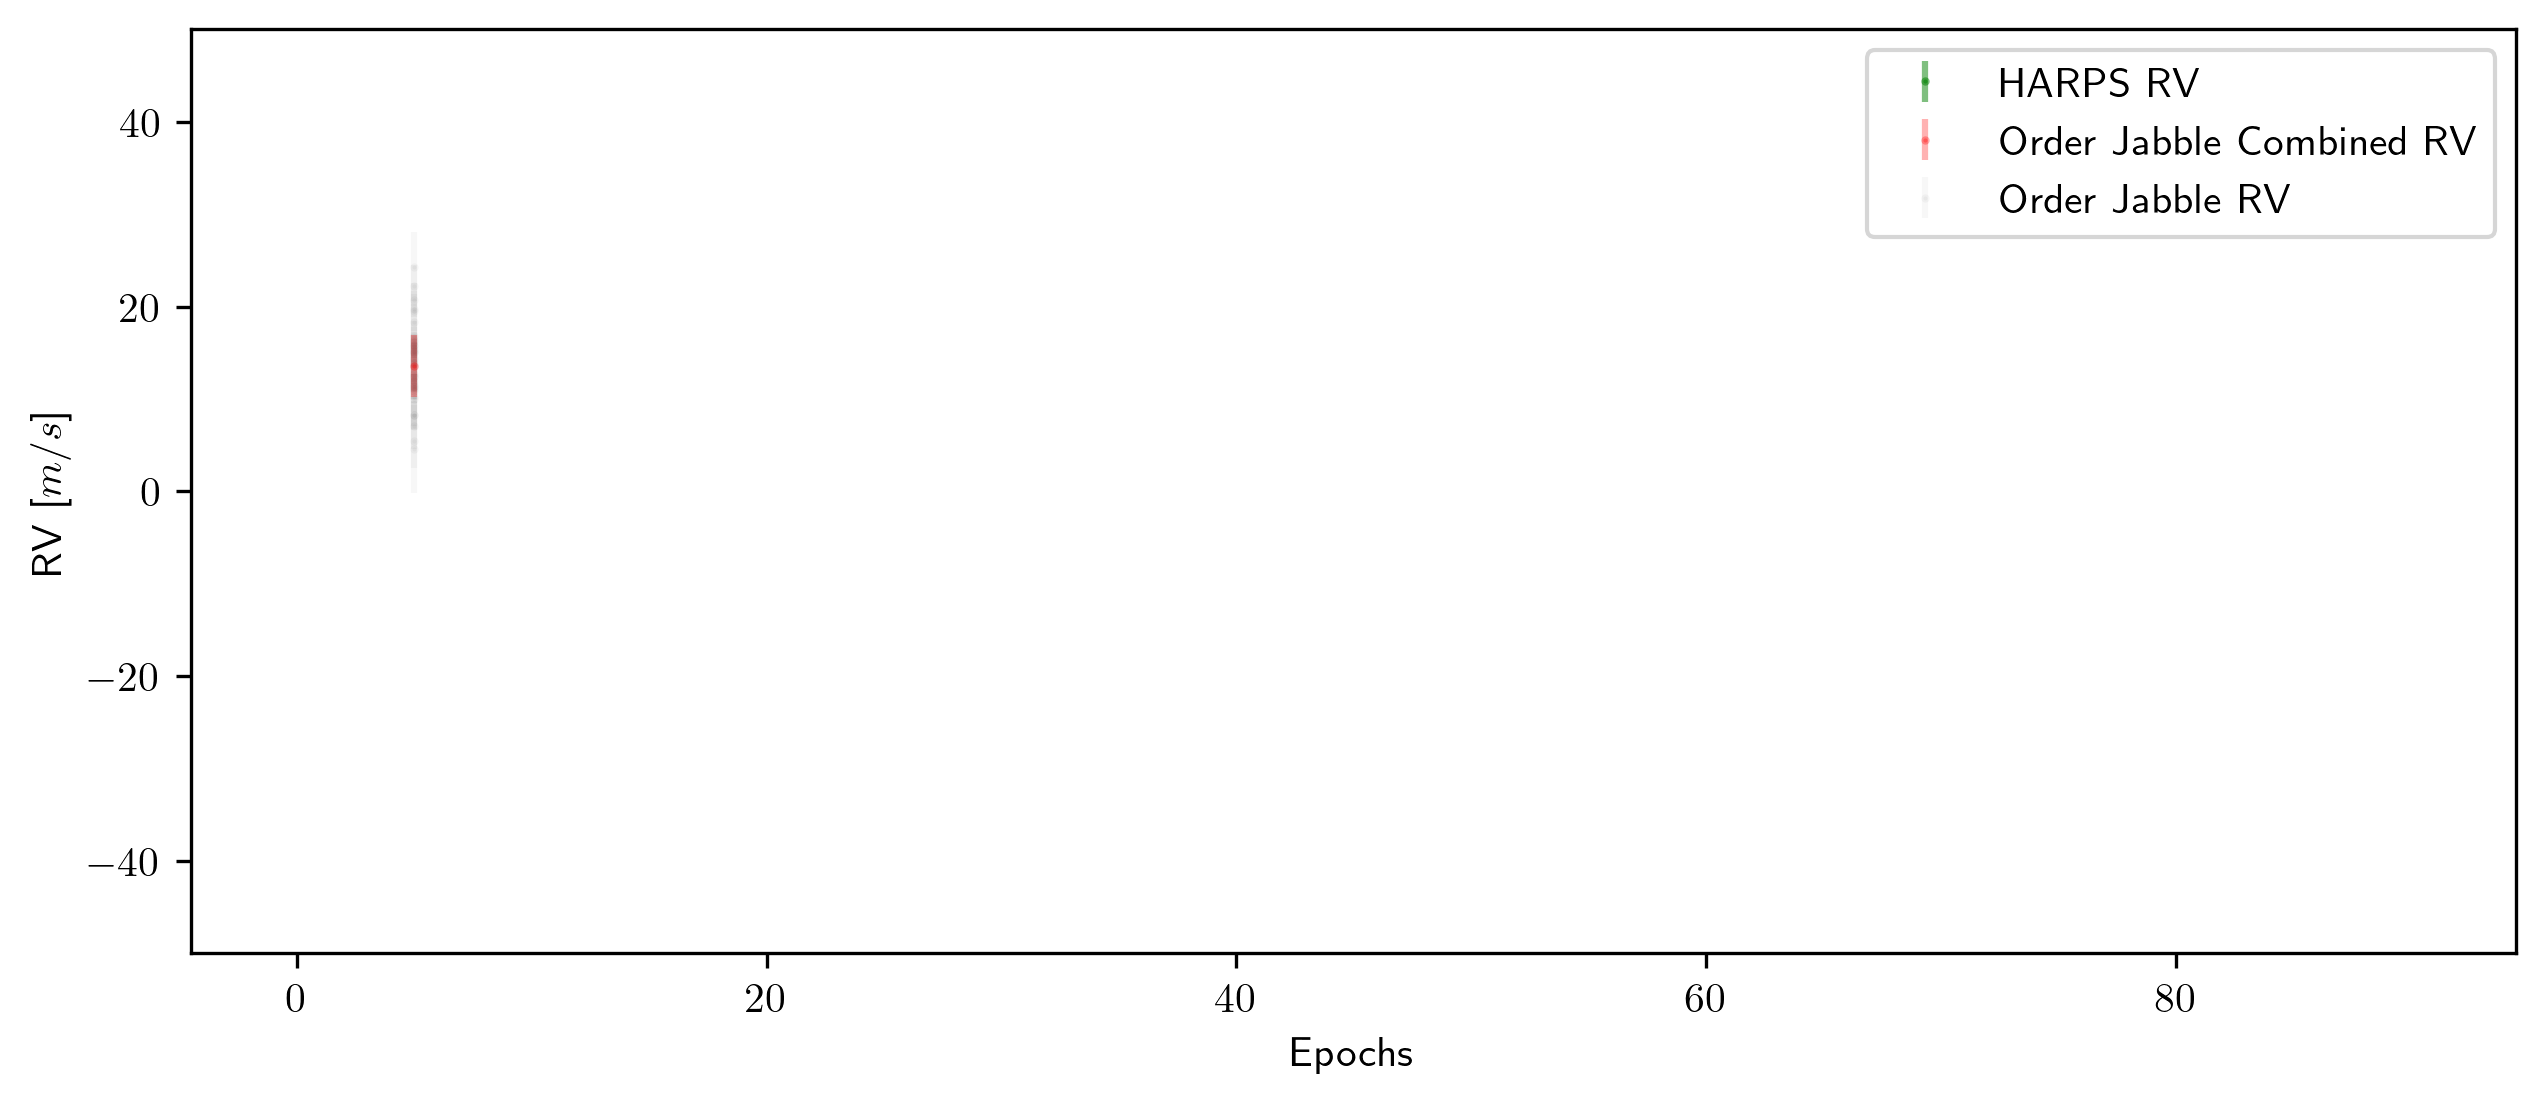

In [152]:
jabble.plotting.plt_rv_comparison(all_rv_array['Time_all'],all_rv_array['RV_all'],all_rv_array['RV_err_all'],\
                        rv_array['Time_comb'],rv_array['RV_comb'],rv_array['RV_err_comb'],\
                        np.array(file_b['dates']),np.array(file_b['pipeline_rvs']),np.array(file_b['pipeline_sigmas']),\
                        np.array(file_b['bervs']),all_rv_array['Loss_Avg'],all_rv_array['RV_difference'],star_name,out_dir)

/state/partition1/job-62140155/ipykernel_1117402/212954366.py:35: RuntimeWarning: divide by zero encountered in divide
  axes[0].errorbar(datarow["xs"][:],datarow["ys"][:],yerr=1/np.sqrt(datarow["yivar"][:]),fmt='ok',zorder=3,alpha=0.5,ms=1)


(4096, 91)


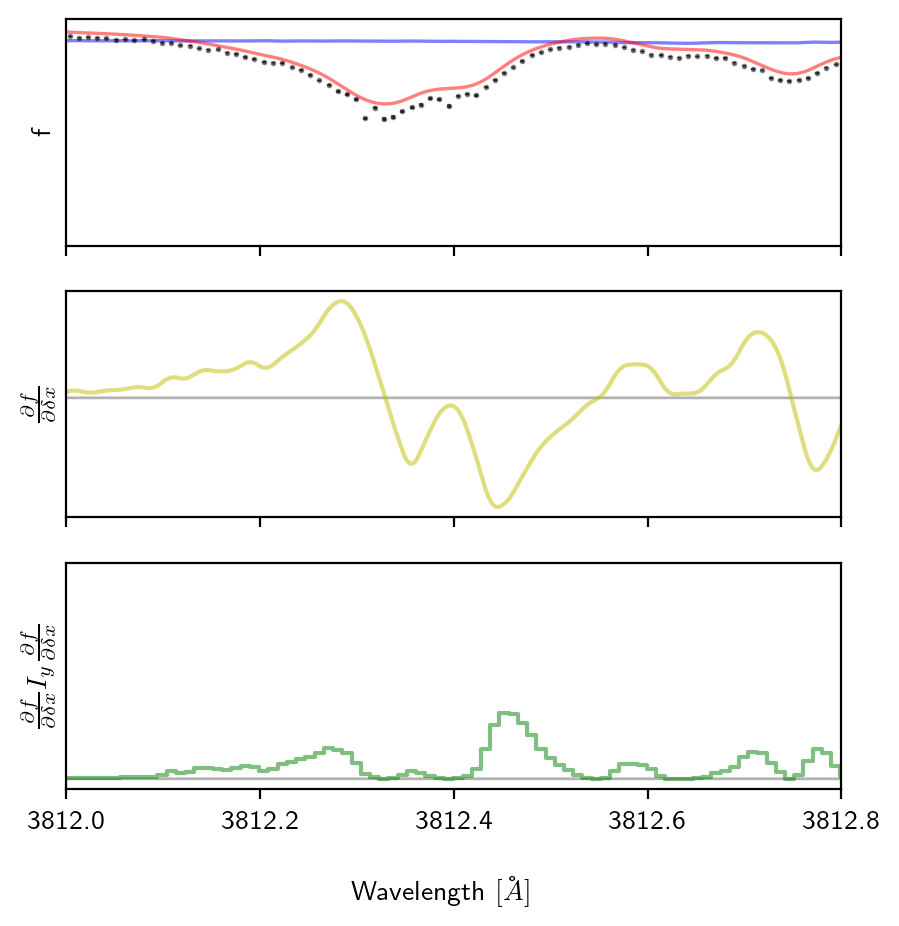

In [133]:
make_deriv_plots(all_data[0],all_models[0],0,cpus[0],'info.png')

dict_keys(['dataset', 'times', 'orders', 'star_ids', 'init_rvs', 'airmass', 'bervs'])
[[5096.09741211 5098.09741211 5100.09741211 5102.09741211 5104.09741211]
 [5096.09741211 5098.09741211 5100.09741211 5102.09741211 5104.09741211]
 [5053.953125   5055.953125   5057.953125   5059.953125   5061.953125  ]
 [5053.953125   5055.953125   5057.953125   5059.953125   5061.953125  ]]


/home/mdd423/wobble_jax/notebooks/../jabble/plotting.py:272: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)
/home/mdd423/wobble_jax/notebooks/../jabble/plotting.py:272: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)
/home/mdd423/wobble_jax/notebooks/../jabble/plotting.py:272: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)
/home/mdd423/wobble_jax/notebooks/../jabble/plotting.py:272: RuntimeWarning: divide by zero encountered in divide
  yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)


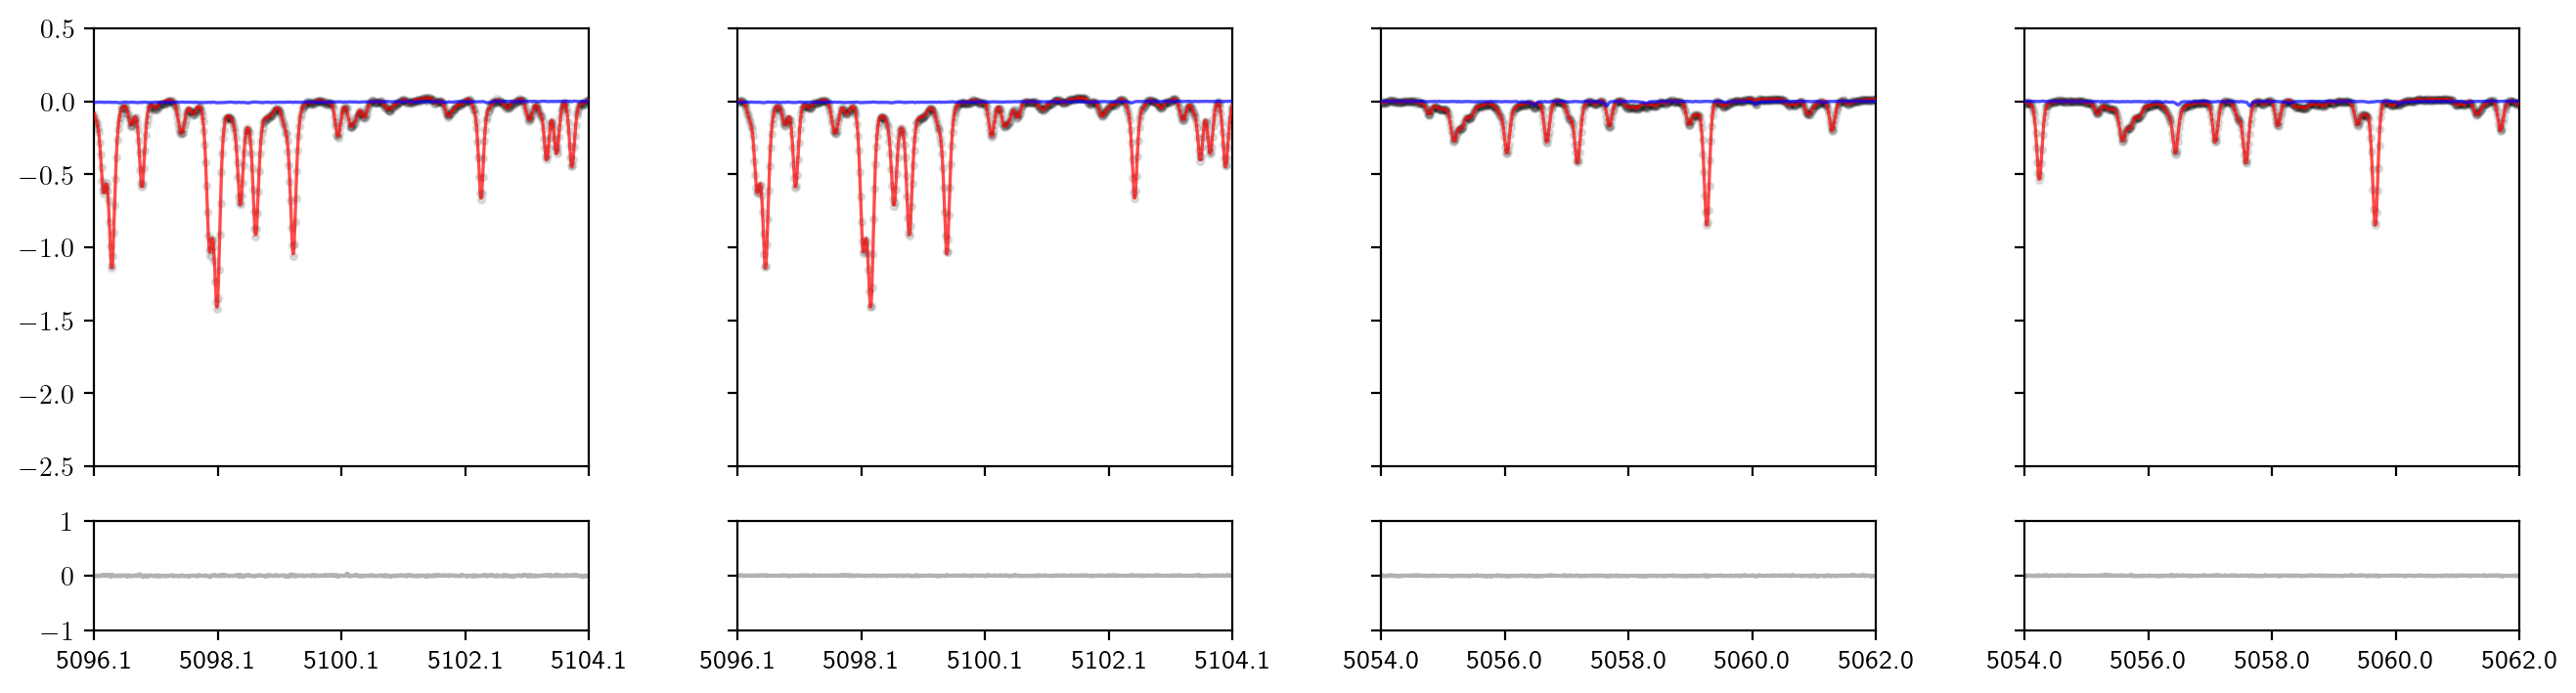

In [134]:
model_index = 20
rv_inds = [-2,-1,0,1]
# rv_data = jabble.physics.velocities(all_models[jjj][0][0].p)
print(all_models[model_index].metadata.keys())
orders = np.unique(all_models[model_index].metadata['orders'])

# dataset, _, _, _, _ = get_dataset(file_b,orders,cpus[0])
ls_means = np.ceil([np.exp(all_data[model_index].xs[xxx][:]) for xxx in rv_inds]).mean(axis=1)
lrange = ls_means[:,None] + np.arange(-5,5,2)[None,:]
# print(lrange)
# lrange = np.repeat(lrange,len(rv_inds),axis=0) + np.zeros(len(rv_inds))[:,None]
plt_name = "{}_spectra_{}.png".format(star_name,orders)
print(lrange)
jabble.plotting.make_order_plot(all_data[model_index],all_models[model_index],lrange,rv_inds,cpus[0],plt_name)
#(dataset,model,lrange,rv_inds,device,plt_name=None)

In [135]:
from astropy.io import fits

In [136]:
line_fits = fits.open('~/wobble_jax/data/J_ApJ_795_23_table2.dat.fits')

In [137]:
# def gaussian_smooth(x,sigma):

#     return np.exp(-x**2/(2*sigma**2))

# def convolve_load(file,sigma_l,xl,eval_a):
#     # This reads in line by line a phoenix model
#     # storing flux and x values to the cache around the grid point
#     # then convolves to instrument resolution
    
#     xl_ii   = 0
#     xl_curr = xl[xl_ii]
#     fl = np.zeros(xl.shape)

#     x_cache = np.array([])
#     f_cache = np.array([])

#     # xh = []
#     # fh = []
#     with open(file,'r') as file_stream:
#         cnt = 0
#         for line in file_stream:
#             cnt += 1
#             if cnt > 8:
#                 words = line.split('    ')
#                 for word in words:
#                     try:
#                         x_val = np.log(np.double(word))
#                         break
#                     except ValueError:
#                         pass
                        
#                 if x_val > (xl_curr - eval_a):
#                     x_cache = np.append(x_cache,x_val)
#                     # xh.append(x_val)
#                     for word in words[::-1]:  
#                         try:
#                             f_cache = np.append(f_cache,np.double(word))
#                             # fh.append(np.double(word))
#                             break
#                         except ValueError:
#                             pass
#                 if x_val > (xl_curr + eval_a):
#                     kern = gaussian_smooth(x_cache - xl_curr,sigma_l)
#                     if xl_ii+1 >= len(xl):
#                         break
#                     else:
#                         fl[xl_ii] = np.dot(f_cache,kern)/np.sum(kern)
#                         xl_ii += 1
#                         xl_curr = xl[xl_ii]
#                         # print(x_cache.shape,f_c
#                         f_cache = f_cache[x_cache > xl_curr - eval_a]
#                         x_cache = x_cache[x_cache > xl_curr - eval_a]
                        

#     return fl
                    
# # x_cache = np.concatenate((x_cache,[np.double(word)]))
# low_resolution = 115_000
# x_min = np.log(4000)
# x_max = np.log(4200)
# sigma_l = jabble.physics.delta_x(low_resolution)

# xl = np.arange(x_min,x_max,sigma_l/2)
# fl = convolve_load('../../wobble_jax/data/models_1721076003/bt-settl/lte032-5.0-0.5a+0.2.BT-NextGen.7.dat.txt',\
#                        sigma_l,xl,3*sigma_l)

In [138]:
# plt.plot(xl,fl,label='low',alpha=0.3)
# plt.plot(xl,fl,marker='.',label='low',alpha=0.4)
# plt.plot(xh,fh,label='high',alpha=0.3)
# # plt.plot(xl.mean() + x_space,y_space,label='kernel')
# plt.xlim(np.log(4010),np.log(4020))
# plt.legend()
# plt.show()

In [139]:
# import nifty_ls
# import nifty_ls
# from astropy.timeseries import LombScargle

In [140]:
# def nifty_ls_diagram(dates,rvs,error,title,plt_name):
#     # print(dates)
#     nifty_res = nifty_ls.lombscargle(dates, rvs, dy=error, fmin=0.01, fmax=0.3)

#     # help(nifty_res)
#     plt.figure(figsize=(10,4))
#     plt.plot(1/nifty_res.freq(),nifty_res.power,'-m',markersize=0.2,alpha=0.7)
#     plt.xlabel('Period (Days)')
#     plt.ylabel('Power')
#     plt.title(title)
#     plt.ylim(0.0,0.3)
#     plt.savefig(os.path.join(out_dir, plt_name))
#     plt.show()

# # print(np.array(file_b['dates']).shape,np.array(jabble_file['RV']).shape,np.array(jabble_file['RV_err']).shape)
# # print(np.array(file_b['dates']).shape,np.array(jabble_file['RV_comb']).shape,np.array(jabble_file['RV_comb_err']).shape)
# plt_name = 'ls_jabble_noberv.png'
# nifty_ls_diagram(np.array(file_b['dates']),rv_array['RV_comb'] + np.array(file_b['bervs']),rv_array['RV_err_comb'],title="Jabble - BERV",plt_name=plt_name)
# plt_name = 'ls_hires_noberv.png'
# nifty_ls_diagram(np.array(file_b['dates']),np.array(file_b['pipeline_rvs']) + np.array(file_b['bervs']),np.array(file_b['pipeline_sigmas']),title="HIRES - BERV",plt_name=plt_name)
# plt_name = 'ls_berv.png'
# nifty_ls_diagram(np.array(file_b['dates']),np.array(file_b['bervs']),None,title="BERVS",plt_name=plt_name)

In [141]:
# all_models[-1].results

In [142]:
# frequency, power = LombScargle(np.array(file_b['dates']), jabble_file['RV_comb']).autopower(method="fastnifty")

In [143]:
line_list[1].data["Species"]

array([ 6. ,  6. ,  6. ,  6. ,  6. ,  8. ,  8. ,  8. , 11. , 11. , 11. ,
       11. , 12. , 12. , 12. , 12. , 12. , 13. , 13. , 13. , 13. , 13. ,
       13. , 14. , 14. , 14. , 14. , 14. , 14. , 14. , 14. , 14. , 14. ,
       14. , 14. , 14. , 14. , 16. , 16. , 16. , 16. , 16. , 16. , 19. ,
       19. , 19. , 19. , 19. , 20. , 20. , 20. , 20. , 20. , 20. , 20. ,
       20. , 20. , 20. , 20. , 21. , 21. , 21. , 21. , 21.1, 21.1, 21.1,
       21.1, 21.1, 21.1, 21.1, 22. , 22. , 22. , 22. , 22. , 22. , 22. ,
       22. , 22. , 22. , 22. , 22. , 22. , 22. , 22. , 22. , 22. , 22. ,
       22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1, 22.1,
       22.1, 23. , 23. , 23. , 23. , 23. , 23. , 23. , 23. , 23. , 24. ,
       24. , 24. , 24. , 24. , 24. , 24. , 24. , 24. , 24. , 24. , 24. ,
       24. , 24. , 24.1, 24.1, 24.1, 24.1, 24.1, 24.1, 24.1, 25. , 25. ,
       25. , 25. , 25. , 25. , 25. , 25. , 26. , 26. , 26. , 26. , 26. ,
       26. , 26. , 26. , 26. , 26. , 26. , 26. , 26

In [144]:
l_min = np.exp(np.array([np.min([np.min(xs) for xs in dataset.xs]) for dataset in all_data]))
l_max = np.exp(np.array([np.max([np.max(xs) for xs in dataset.xs]) for dataset in all_data]))

In [ ]:
ls_midpoint = 6560.000
lrange = np.ceil(ls_midpoint) + np.arange(-10.0,10.0,4.0)
model_index = np.where((ls_midpoint > l_min)*(ls_midpoint < l_max))[0][0]
print(model_index)

# orders = np.unique(all_models[model_index].metadata['orders'])

# data, meta = dataset.blockify(cpus[0])
rest_shifts = np.zeros(all_models[model_index][0][0].p.shape)
index_sort = np.argsort(rest_shifts)
residual_resolution = 512
orders_plt = np.unique(all_models[model_index].metadata['orders'])
print(orders_plt)
plt_name = "res_img_{}_o{}-{}_l{}-{}_.png".format(star_name,np.min(orders_plt),np.max(orders_plt),np.min(lrange),np.max(lrange))
plt_epochs, = np.where(all_data[model_index].metadata['orders'] == 67)
fig, ax = jabble.plotting.plot_earth_residual_img_with_spec(all_models[model_index],all_data[model_index],lrange,plt_epochs,100,\
                        rest_shifts,residual_resolution,plt_name,device=cpus[0],out_dir=out_dir)
fig.savefig(os.path.join(out_dir,plt_name),bbox_inches='tight')

# ax[2,0].text()
# plot_earth_residual_img_with_spec(model,dataset,lrange,plt_epochs,spec_epoch,rest_shifts,residual_resolution,
# plt_name,out_dir,device,res_max=0.1):


rv_inds = [0,1,-2,-1]
lrange_stack = np.ones(len(rv_inds))[:,None] * lrange[None,:]
plt_title = "Barnard\'s Star"
plt_name = "spectra_{}_o{}-{}_l{}-{}_.png".format(star_name,orders_plt.min(),orders_plt.max(),np.min(lrange),np.max(lrange))
# make_order_plot(all_data[model_index],all_models[model_index],lrange,rv_inds,cpus[0],plt_name)
shift_by_eye = 0#np.log(5001/5000)
jabble.plotting.make_order_plot(all_data[model_index],all_models[model_index],lrange_stack,\
                                rv_inds,cpus[0],plt_name=plt_name,out_dir=out_dir,title=plt_title,line_list=line_list)

In [ ]:
# lmin = 5580
# lmax = 5585
# lspacing = 1
# residual_resolution = 2048
# lrange = np.arange(lmin,lmax+lspacing,lspacing)
# plt_name =  "02-{}_res_img_starref.png".format(os.path.split(model_name_b)[-1],np.min(orders),np.max(orders))

# rest_vel = model_b[0][0].p#np.zeros(.shape)
# index_sort = np.argsort(rest_vel)
# rest_shifts =  model_b[0][0].p#jabble.physics.shifts(rest_vel)

In [ ]:
# for filename in dir:
#     model = jabble.model.load(filename)
#     rv_data = jabble.physics.velocities(model[0][0].p)
#     orders = np.unique(model.metadata['orders'])
#     lmean = np.mean(np.exp(model[0][1].xs))
#     lmin = lmean-10
#     lmax = lmean+10
#     lspace = 4
    
#     lrange = np.arange(lmin,lmax+lspace,lspace)
    
#     rv_inds = [-1,0,1]
#     make_order_plot(file_b,model,lmin,lmax,lrange,[orders[1]],rv_inds,cpus[0])

In [ ]:
# def imshow_rv_difference(all_models,times_t,times_e,rv_e,err_e,bervs,):
    
#     rv_array = np.zeros((len(all_models),*all_models[0][0][0].p.shape))
#     order_array = []

#     info_e = 1/err_e**2
#     epoches_span_e = np.zeros(len(rv_e))

#     rv_comb = jnp.array(len(times_t))
#     for iii,time in enumerate(times_t):
#         indices = times_e == time

#         rv_indiv[indices] = rv_e[indices] + bervs[iii] - correct_vel[iii]
#         epoches_span_e[indices] = iii
#         rv_comb = rv_comb.at[iii].set(jnp.dot(info_e[indices],rv_e[indices])/jnp.sum(info_e[indices]))
#         info_comb = info_comb.at[iii].set((jnp.dot(info_e[indices],rv_e[indices]**2)/jnp.sum(info_e[indices])) - rv_comb[iii]**2)


#     for i,model in enumerate(all_models):
#         # data, _, _, full_init_shifts, _ = get_dataset(file_b,orders,cpus[0])
#         datablock, metablock, keys = data.blockify(cpus[0],return_keys=True)
#         rv_array[i,:] = jabble.physics.velocities(model[0][0].p)
#         order_array.append(np.unique(model.metadata['orders']))



In [ ]:
# imshow_rv_difference(all_models)

5577 night sky line

In [ ]:
# modelname = 'barnardsvmapmodel1.mdl'
# # model = jabble.model.load(modelname)
# jabble.model.save(modelname,model)

In [ ]:
# def make_plot(model,dataset,init_shifts,filename):
#     x_window = np.log(4550) - np.log(4549)
#     lmin = np.exp(dataset.xs[0,500])
#     lmax = np.exp(dataset.xs[0,1500])
#     lrange = np.arange(lmin,lmax,5)
#     plt_unit = u.Angstrom
#     epoches = 25
#     r_plots = 5

#     vel_epoch = 5
#     fig, axes = plt.subplots(
#         epoches // r_plots,
#         r_plots,
#         figsize=(8, 8),
#         sharex=False,
#         sharey=True,
#         facecolor=(1, 1, 1),
#         dpi=200,
#     )
#     # fig.suptitle(filenames[model_num])
#     for plt_epoch in range((epoches // r_plots) * r_plots):
#         xplot = np.linspace(np.log(lmin), np.log(lmax), dataset.xs.shape[1] * 10)
#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(
#             xplot.min() + model[0][0].p[plt_epoch],
#             xplot.max() + model[0][0].p[plt_epoch],
#         )

#         # model_set[model_num].fix()
#         # model_set[model_num].fit(0)
#         # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),dataset.xs[plt_epoch,:],plt_epoch)
#         # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])

#         model.fix()

#         axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(
#             dataset.xs[plt_epoch, :],
#             dataset.ys[plt_epoch, :],
#             dataset.yerr[plt_epoch, :],
#             fmt=".k",
#             elinewidth=1.2,
#             zorder=1,
#             alpha=0.5,
#             ms=3,
#         )

#         # true_model.fix()

#         axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(
#             xplot,
#             model([], xplot, plt_epoch),
#             "-r",
#             linewidth=1.2,
#             zorder=2,
#             alpha=0.5,
#             ms=6,
#         )
#         # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2, 1)
#         #         axes[i,j].set_yticks([])
#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
#         axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(
#             ["{:2.0f}".format(x) for x in lrange]
#         )

#         res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
#         residual = loss(
#             model.get_parameters(),
#             dataset,
#             plt_epoch,
#             model,
#         )
#         res_ax.step(
#             dataset.xs[plt_epoch, :], residual, where="mid", alpha=0.3, label="residual"
#         )
#         res_ax.set_ylim(0.0, 20)
#         res_ax.set_yticks([])
#         # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
#         #             model_set[i][j].results[-2]['grad'][:],\
#         #             where='mid',alpha=0.4,label='residual',zorder=-1)
#         # res_ax.set_yticks([])

#         # res_ax.step(x_grid,\
#         #             rv_model_deriv[:,plt_epoch],\
#         #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

#         #     res_ax.step(x_grid,\
#         #                 rv_loss_deriv[:,plt_epoch],\
#         #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

#         #     align_yaxis(, 0, , 0)

#         align.yaxes(
#             axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2.0 / 3.0
#         )

#     # res.get_shared_y_axes().join(ax1, ax3)
#     fig.text(0.5, 0.04, "$\lambda$", ha="center")
#     fig.text(0.04, 0.5, "y", va="center", rotation="vertical")
#     # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
#     # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
#     fig.text(0.96, 0.5, "residuals", va="center", rotation=270)

#     plt.savefig(
#         os.path.join(out_dir, "02-res_{}.png".format(filename)),
#         dpi=300,
#         bbox_inches="tight",
#     )
#     plt.show()

6563 h alpha

In [ ]:
# filenames = ['51peg','barnards']
# make_plot(model_b,dataset_b,shifts_b,filenames[1])

In [ ]:
# with open('../data/models_1721076003/bt-settl/lte032-5.0-0.5a+0.2.BT-NextGen.7.dat.txt', 'r') as f:
#     # text = f.read()
#     cnt = 0
#     for line in f:
        
#         cnt += 1
#         if cnt > 8:
#             print([np.double(x) for x in line.split("    ")[-2:]])

#         if cnt > 12:
#             break
        

# # print(text)

In [ ]:
# def make_better_plot(model_set,datasets,file_set):
    

#     fig, axes = plt.subplots(2*len(model_set),4,figsize=(4*4,4*len(model_set)),sharex=True,facecolor=(1, 1, 1),dpi=200,height_ratios=[4,1]*len(model_set))
    
#     for jj,(model,dataset,file) in enumerate(zip(model_set,datasets,file_set)):
#         x_window = np.log(4550) - np.log(4549)
#         lmin = np.exp(dataset.xs[0,0])
#         lmax = np.exp(dataset.xs[0,2000])
#         lrange = np.arange(lmin,lmax,5)
#         sort_airmasses = np.argsort(np.array(file['airms'][:]))
#         plt_epochs = np.concatenate((sort_airmasses[:2],sort_airmasses[-2:]))
        
        
        
        
#         offset = 1.0
#         xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs.shape[1]*10)
#         for ii,plt_epoch in enumerate(plt_epochs):
#             axes[2*jj,ii].set_xlim(xplot.min()+model[0][0].p[plt_epoch],xplot.max()+model[0][0].p[plt_epoch])
            
#             model.fix()
            
#             axes[2*jj,ii].errorbar(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:],\
#                                      dataset.yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
            
#             axes[2*jj,ii].plot(xplot,offset + model[0]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             axes[2*jj,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             axes[2*jj,ii].plot(xplot,model[2]([],xplot,plt_epoch),'-m',linewidth=1.2,zorder=3,alpha=0.7,ms=6)
            
#             # axes[0,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             # axes[0,ii].plot(xplot,offset + model([],xplot,plt_epoch),'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
#             # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
            
            
#             axes[2*jj,ii].set_ylim(-2,3)
#             axes[2*jj,ii].set_xticks([])
#             # axes[0].set_yticks([])
#             axes[2*jj+1,ii].set_xticks(np.log(lrange))
#             axes[2*jj+1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
            
#             axes[2*jj+1,ii].plot(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:] - model([],dataset.xs[plt_epoch,:],plt_epoch),'.k',alpha=0.4,ms=1)
            
#             axes[2*jj+1,ii].set_ylim(-0.1,0.1)
#             axes[2*jj,ii].set_title('airmass = {}'.format(file['airms'][:][plt_epoch]))
#         # res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
#         # residual = loss(model_set[model_num].get_parameters(),dataset,plt_epoch,model_set[model_num])
#         # res_ax.step(dataset.xs[plt_epoch,:],residual,where='mid',alpha=0.3,label='residual')
#         # res_ax.set_ylim(0.0,20)
#         # res_ax.set_yticks([])
#         # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
#         #             model_set[i][j].results[-2]['grad'][:],\
#         #             where='mid',alpha=0.4,label='residual',zorder=-1)
#         # res_ax.set_yticks([])
        
#         # res_ax.step(x_grid,\
#         #             rv_model_deriv[:,plt_epoch],\
#         #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
#         #     res_ax.step(x_grid,\
#         #                 rv_loss_deriv[:,plt_epoch],\
#         #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
#         #     align_yaxis(, 0, , 0)
            
#             # align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)
        
#         # res.get_shared_y_axes().join(ax1, ax3)
#         fig.text(0.5, 0.04, '$\lambda$', ha='center')
#         # fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
#         # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
#         # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
#         # fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
#     # plt.savefig(os.path.join(out_dir,'02-full-barn-51peg.png'),dpi=300,bbox_inches='tight')
#     plt.show()

In [ ]:
# make_better_plot(model_set,datasets,file_set)

In [ ]:
# tell_loss = [[],[]]
# for jjj, (dataset, model) in enumerate(zip(datasets,model_set)):
#     for iii in range(dataset.ys.shape[0]):
#         tell_loss[jjj].append(loss([],dataset,iii,model[0]).sum())

# plt.plot(np.array(file_p['airms'][:]),tell_loss[0],'.k',label='51 peg')
# plt.plot(np.array(file_b['airms'][:]),tell_loss[1],'.r',label='barnards')
# # plt.ylim(0.0,5e4)

# # plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
# # plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
# plt.xlabel('airmass')
# plt.ylabel('$\Sigma_* (y_* - \hat{y}_s(x_*)) I_{y*}$')
# # plt.plot()
# plt.legend()
# # plt.savefig(os.path.join(out_dir,'02-airmass_loss.png'),dpi=300,bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
# plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
# plt.xlabel('airmass')
# plt.ylabel('~a')
# x_space = np.linspace(np.min(np.array(file_b['airms'][:])),np.max(np.array(file_b['airms'][:])))
# plt.plot(x_space,x_space,'-.k',alpha=0.3)
# plt.legend()
# # plt.savefig(os.path.join(out_dir,'02-airmass_an.png'),dpi=300,bbox_inches='tight')
# plt.show()

In [ ]:
# fig, axes = plt.subplots(1,figsize=(4,4),sharex=True,facecolor=(1, 1, 1),dpi=200)

# plt_epoch = 10
# x_window = np.log(4550) - np.log(4549)
# lmin = np.exp(dataset_p.xs[0,500])
# lmax = np.exp(dataset_p.xs[0,1500])
# lrange = np.arange(lmin,lmax,5)
# xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset_p.xs.shape[1]*10)
# axes.plot(xplot,model_p[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='51 peg')
# axes.plot(xplot,0.05 + model_b[1]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='barnard')
# axes.legend()

# axes.set_ylim(-0.2,0.1)
# axes.set_xticks([])
# axes.set_ylabel('log flux + offset')
# axes.set_xlabel('$\lambda$')
# axes.set_xticks(np.log(lrange))
# axes.set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
# plt.title('just tellurics')
# # plt.savefig(os.path.join(out_dir,'02-airmass-tell.png'),dpi=300,bbox_inches='tight')
# plt.show()